# 1. Prerequisites

Neural networks have four building blocks that define how the network operates and how it is trained. As the network architectures have become increasingly complex the details of how the networks are trained have similarly increased, how large the mini batches are, what optimizer to use etc. For instance, see `RoBERTa: A Robustly Optimized BERT Pretraining Approach` (https://arxiv.org/abs/1907.11692).

The four main components of a trained neural network are

- the network architecture
    - feed forward, recurrent, transformer?
    - how many layers?
    - how wide are the layers?
- the optimizer
    - SGD
    - Adam
    - AdamW
- the scheduler
    - constant
    - slanted learning rates
- the learning objective and loss function
    - this is problem dependent
    - masked language model (MLM)
    - causal language model (CLM)
    - translation language model (TLM)
    - classification

https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html


## 1.1 Network Architecture

The networks architecture is perhaps the most visible part of the four. It defines how the individual (artificial) neurons work and how they connect together. At its simplest the network is a fully connected feed forward network with sigmoid as the activation function for the neurons.

In [8]:
import torch
from torch import nn
from torch.nn import functional as F

class FeedForward(nn.Module):
    def __init__(self, layers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # create feed forward layers
        self.layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features)
                                     for (in_features, out_features) in layers])
        
        # TODO: initialise weights
        
        # create activation functions for each layer
        self.activation = torch.nn.Sigmoid()

    def forward(self, X, labels=None):
        output = None
        for i_layer, layer in enumerate(self.layers):
            if output is None:
                output = self.activation(layer(X))
            else:
                output = self.activation(layer(output))
        # do softmax
        prob = F.log_softmax(output, dim=1).exp()
        return prob


n_classes = 2
n_features = 50
layer_spec = [(n_features, 25), (25, n_classes)]
ff = FeedForward(layers=layer_spec)

inputs = torch.randn((10, n_features), dtype=torch.float32)
ff(inputs).detach().numpy()

array([[0.49201864, 0.50798136],
       [0.4932044 , 0.50679564],
       [0.49051538, 0.5094846 ],
       [0.49539065, 0.50460935],
       [0.4970286 , 0.5029715 ],
       [0.5063873 , 0.4936127 ],
       [0.4970608 , 0.5029392 ],
       [0.4944676 , 0.50553244],
       [0.50102276, 0.49897727],
       [0.49211037, 0.50788957]], dtype=float32)

## 1.2 Optimizer and Scheduler

- http://ruder.io/optimizing-gradient-descent/
- http://cs231n.github.io/optimization-1/

## 1.3 Training the Network

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X, y = make_blobs(n_samples=500, n_features=n_features, centers=2)
X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
sampler = RandomSampler(train_dataset)

# Utilize the data loader from pytorch to create batches of data 
train_data = DataLoader(train_dataset, sampler=sampler, batch_size=8)

### 1.3.1 A Learning Function
Define a training function that loops through the training data some number of times and updates the model weights as well as the learning rate schedule.

__Note__ that each iteration over the inner for loop takes _one batch_ of data from the `pytorch` data loader class. The batch size determines how much data is used to compute the gradient. ___This will become important later!___


In [32]:
def train_model(model: nn.Module,
                data: DataLoader,
                criterion: nn.modules.loss._Loss,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler,
                n_epochs: int = 1):
    model.train()
    losses = []
    # for each epoch
    for i_epoch in range(n_epochs):
        optimizer.zero_grad()
        # go through the training data one batch at a time
        for x_, y_ in data:
            # Forward pass
            y_pred = model(x_)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_)
            losses.append(loss)
            
            # Backprop loss
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update learning rate schedule
            scheduler.step()
    return model, losses

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

model = FeedForward(layer_spec)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = LambdaLR(optimizer, lambda epoch: 1e-3)

trained_model, losses_sgd = train_model(model, train_data, criterion, optimizer, scheduler, n_epochs=15)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
trained_model, losses_adam = train_model(model, train_data, criterion, optimizer, scheduler, n_epochs=15)

The choice of optimizer makes quite a difference. As the network becomes larger (more parameters) and the problme more complex the optimizer becomes increasingly important.

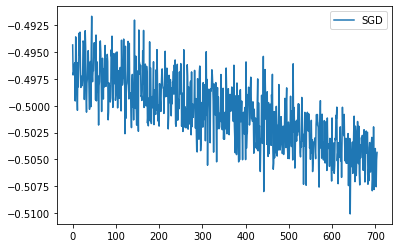

In [37]:
%matplotlib inline

plt.plot(losses_sgd, label='SGD');
plt.legend();

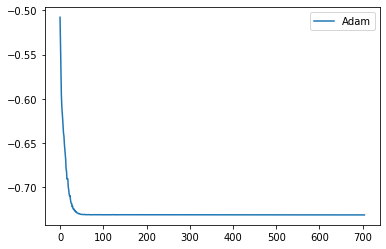

In [38]:
plt.plot(losses_adam, label='Adam');
plt.legend();

---

# 1.4 Natural Language (text) to Linear Algebra

The dummy data set we used in the previous section was already vectors so that no work was required to transform the data into something (a vector) a neural network can consume. Natural langauge text, or `python` source code for that matter, does not come in this readily available form so some amount of preprocessing is required.

The great promise of artificial neural networks for NLP is that a lot of the feature engineering work that has in the past been done by arduous PhD students can be offloaded to the combination of neural network machinery, gradient descent and the loss function to be minimised. Optimising a loss function given some training data may lead to problems down the line in the networks ability to [generalise to other kinds of data](https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/), but we'll forego that concern here.

## 1.4.1 Representing Natural Language - a Computer Science Perspective

Natural languages are ambiguous, complex and highly expressive ways of encoding information, not just semantics but also a lot of cultural details like class hierarchies and history. The Viking conquests are present in the everyday usage of english. We grow _cows_ _pigs_ and _lamb_ but eat _beef_ _pork_ and _mutton_, at least the non-vegetarians do. In finnish _vasta_ and _vihta_ refer to a collection of young leafy birch branches used when bathing (sauna), however _vihta_ is only ever used in western Finland and _vasta_ only in eastern Finland. Whether or not these etymological tidbits and subtle differences in the semantics of the words are necessary or even helpful in solving some task remains debatable.

Word vectors, also known as _embeddings_, aim to create word representations that capture distributional similarity between words as vectors. Specifically, the word vectors should act in such a way that algebraic modifications maintain the semantic coherence. By capturing distributional similarity they end up capturing semantic information about words and their relations and thus allow for a somewhat coherent way of encoding natural language text into vectors.

These vectors can be used to encode documents for neural networks.

## 1.4.2 A Text Classifier with Embeddings

Below, we'll use the fastText word embeddings to create a document classifier for the 20 newsgroups data set.

In [39]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  650M  100  650M    0     0  4153k      0  0:02:40  0:02:40 --:--:-- 4412k    0   282k      0  0:39:14  0:00:02  0:39:12  282k8M    0     0  4143k      0  0:02:40  0:01:40  0:01:00 3247k


In [40]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


# Word vectors (fastText)

Much has been said about word vectors, and as a result I won't go into a lot of detail here, but instead simply refer to the existing excellent resources that are already available.

- https://colah.github.io/posts/2014-07-NLP-RNNs-Representations/
- http://www.offconvex.org/2015/12/12/word-embeddings-1/
- https://www.offconvex.org/2016/02/14/word-embeddings-2/
- [A Latent Variable Model Approach to PMI-based Word Embeddings](https://arxiv.org/abs/1502.03520)

In short word vectors are a way of capturing and representing information about distributional semantics in a way that is convenient for computers to deal with. More to the point, they allow arithmetic operations that are, at least to an extent, semantically coherent.

In [49]:
from gensim.models import KeyedVectors
ft_vec = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [50]:
ft_vec.most_similar('Berlin')

[('Hamburg', 0.7192949056625366),
 ('Leipzig', 0.7079555988311768),
 ('Germany', 0.7065215706825256),
 ('Bonn', 0.6962816715240479),
 ('Frankfurt', 0.6828957796096802),
 ('Munich', 0.6818759441375732),
 ('Dresden', 0.6666932106018066),
 ('Charlottenburg', 0.6547130346298218),
 ('Cologne', 0.6527723073959351),
 ('Potsdam', 0.6491366624832153)]

In [51]:
ft_vec.most_similar('Python')

[('python', 0.7034494280815125),
 ('Pythons', 0.7013207674026489),
 ('molurus', 0.6848306655883789),
 ('Stackless', 0.6760033369064331),
 ('Pygame', 0.6643676161766052),
 ('Monthy', 0.6636004447937012),
 ('PyGTK', 0.635582447052002),
 ('NumPy', 0.62997967004776),
 ('sebae', 0.6281064748764038),
 ('CPython', 0.6107180118560791)]

---

Load the data and turn it something that can be fed into a network.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(data_home='./data', remove=('headers', 'footers', 'quotes'))

In [ ]:
news.keys()

In [19]:
news['target_names'][:3], news['target'][:3]

(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc'], array([7, 4, 4]))

Create an index for fords

In [56]:
word2idx = dict((w, idx) for (idx, w) in enumerate(model.index2word))

In [57]:
word2idx['Berlin']

2918

In [63]:
import pandas as pd

pd.DataFrame([(idx, word, ft_vec[word])
              for idx, word in enumerate(ft_vec.index2word[:80:5])],
             columns=['idx', 'word', 'vector']).set_index('idx')

,word,vector
idx,,
0,",","[0.1073, 0.0089, 0.0006, 0.0055, -0.0646, -0.0..."
1,to,"[0.0495, 0.0411, 0.0041, 0.0309, -0.0044, -0.1..."
2,),"[-0.0675, 0.0383, -0.0183, 0.0028, -0.0074, -0..."
3,on,"[0.0206, 0.0231, -0.0574, 0.0388, -0.1158, -0...."
4,The,"[0.0797, -0.0294, 0.0033, 0.0458, 0.0174, -0.0..."
5,by,"[0.0242, -0.0265, 0.0822, -0.0322, 0.0042, -0...."
6,you,"[-0.1202, 0.07, 0.103, 0.0568, 0.1457, -0.1787..."
7,-,"[-0.0092, -0.0478, -0.038, 0.0125, 0.0175, -0...."
8,;,"[0.125, -0.0241, -0.0904, 0.0432, 0.1913, -0.0..."


we set the vector for out-of-vocabulary words to the mean of all other vectors

In [50]:
UNK_vector = model.vectors.mean(axis=0)

---

Extend the feed forward network by adding an embedding layer.

In [48]:
class FeedForwardWithEmbeddings(nn.Module):
    def __init__(self, layers, pretrained_embeddings=None,
                 num_embeddings=None, embedding_dim=50,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        if pretrained_embeddings:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
            self.embedding_dim = embedding.size(1)
            self.num_embeddings = embedding.size(0)
        elif num_embeddings is not None and num_embeddings > 0 and embedding_dim > 0:
            self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        else:
            raise Exception('You must either define pretrained embeddings or both the number and dimensionality of embeddings.')
       
        
        # create feed forward layers
        self.layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features)
                                     for (in_features, out_features) in layers])
        
        # TODO: initialise weights
        
        # create activation functions for each layer
        self.activation = torch.nn.Sigmoid()

    def forward(self, X, labels=None):
        output = None
        X = self.embedding(X)
        for i_layer, layer in enumerate(self.layers):
            if output is None:
                output = self.activation(layer(X))
            else:
                output = self.activation(layer(output))
        # do softmax
        prob = F.log_softmax(output, dim=1).exp()
        return prob 

In [64]:
def tokenize(msg):
    tokens = re.findall('\w+', msg)
    vectors = [word2idx[t] if t in ft_vec else unk_vector
               for t in tokens][:100]
    if len(vectors) < 100:
        vectors += [unk_vector] * (100 - len(vectors))
    return vectors

def map_label(label_idx):
    return news['target_names'][label_idx].split('.')[0]

X, y = zip(*[(tokenize(x), map_label(y_idx)) for x, y_idx in zip(news['data'], news['target'])])
label_map = {label: idx for idx, label in enumerate(set(y))}
y = [label_map[y_] for y_ in y]

NameError: name 'news' is not defined

__Note__: The precomputed fast text word embeddings contain a lot more entries than those in the 20 newsgroups data set. For practical purposes one _could_ leave only those words that are contained in the training data. This, however, comes at the cost of potentially losing information for future unseen words that _are_ in the pretrained fast text embeddings.

In [67]:
set(y)

{0, 1, 2, 3, 4, 5, 6}

In [74]:
from torch.utils.data import RandomSampler, DataLoader, TensorDataset

X = torch.FloatTensor(X)
y = torch.LongTensor(y)
data = TensorDataset(X, y)
sampler = RandomSampler(data)

In [58]:
from tqdm import tqdm_notebook as tqdmn
from torch.nn.utils import clip_grad_norm_

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X.size(0) // (train_dataloader.batch_size + 1),
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = batch
        loss, *_ = bert(batch_X, labels=batch_y)
        loss = loss / gradient_accumulation_steps
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        if (gradient_accumulation_steps <= 1
                or (i_step + 1) % gradient_accumulation_steps == 0):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

---

### Bag of Tricks for Efficient Text Classification
- [Edouard Grave, Tomas Mikolov, Armand Joulin, Piotr Bojanowski: Bag of Tricks for Efficient Text Classification. EACL (2) 2017: 427-431](https://www.aclweb.org/anthology/E17-2068/)


| Model | AG | Sogou | DBP | Yelp P. | Yelp F. | Yah. A. | Amz. F. | Amz. P. |
| ----- | -- | ----- | --- | ------- | ------- | ------- | ------- | ------- |
| BoW (Zhang et al., 2015) | 88.8 | 92.9 | 96.6 | 92.2 | 58.0 | 68.9 | 54.6 | 90.4 |
| ngrams (Zhang et al., 2015) | 92.0 | 97.1 | 98.6 | 95.6 | 56.3 | 68.5 | 54.3 | 92.0 |
| ngrams TFIDF (Zhang et al., 2015) | 92.4 | 97.2 | 98.7 | 95.4 | 54.8 | 68.5 | 52.4 | 91.5 |
| char-CNN (Zhang and LeCun, 2015) | 87.2 | 95.1 | 98.3 | 94.7 | 62.0 | 71.2 | 59.5 | 94.5 |
| char-CRNN (Xiao and Cho, 2016) | 91.4 | 95.2 | 98.6 | 94.5 | 61.8 | 71.7 | 59.2 | 94.1 |
| VDCNN (Conneau et al., 2016) | 91.3 | 96.8 | 98.7 | 95.7 | 64.7 | 73.4 | 63.0 | 95.7 |
| |
| fastText, h = 10 | 91.5 | 93.9 | 98.1 | 93.8 | 60.4 | 72.0 | 55.8 | 91.2 |
| fastText, h = 10, bigram | 92.5 | 96.8 | 98.6 | 95.7 | 63.9 | 72.3 | 60.2 | 94.6 |